## Load the dataset

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt



normalized_data_path = '../Normalization/A1-turbine-normalized.csv'
data = pd.read_csv(normalized_data_path, sep=',', header=0)

print(data.head())


   Height over Sea Level    Fall 1    Fall 2    Fall 3      Flow
0               1.458733  1.494763  1.565871 -1.363870 -0.920759
1              -0.889207 -0.864935 -0.908663  0.322233 -0.087759
2              -1.160123 -1.144520 -1.180093  0.322233 -0.250873
3               1.639344  1.637351  1.545514  1.165284  2.003763
4               0.736290  0.724040  0.742534  0.041216  0.473213


## Data Preprocessing

In [47]:
# separate features and target variable
X = data.drop('Flow', axis=1)  
y = data['Flow']


# split the dataset into training (85%) and testing (15%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
y_test = y_test.values if isinstance(y_test, pd.Series) else y_test


# display the shape of the train and test sets to verify the split
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (382, 4) (382,)
Testing set shape: (68, 4) (68,)


## Model Training

In [48]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def create_model(num_layers, layer_structure, num_epochs, learning_rate, momentum, activation_function):
    model = tf.keras.Sequential()
    
    # Add hidden layers as specified in layer_structure
    for i, units in enumerate(layer_structure[:-1]):  # Exclude the last element for the output layer
        if i == 0:  # First layer needs to specify input shape
            model.add(tf.keras.layers.Dense(units, activation=activation_function, input_shape=(X_train.shape[1],)))
        else:
            model.add(tf.keras.layers.Dense(units, activation=activation_function))
    
    # Output layer with 1 unit for regression
    model.add(tf.keras.layers.Dense(1, activation='linear'))  # Ensure this matches your regression task
    
    if momentum is not None:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model, num_epochs

# Example configurations 
configs = [
    {'num_layers': 2, 'layer_structure': [64, 32], 'num_epochs': 100, 'learning_rate': 0.01, 'momentum': 0.9, 'activation_function': 'relu'},
    {'num_layers': 3, 'layer_structure': [128, 64, 32], 'num_epochs': 150, 'learning_rate': 0.001, 'momentum': None, 'activation_function': 'relu'},
    {'num_layers': 2, 'layer_structure': [32, 16], 'num_epochs': 200, 'learning_rate': 0.0001, 'momentum': None, 'activation_function': 'relu'},
    # {'num_layers': 3, 'layer_structure': [64, 64, 64], 'num_epochs': 100, 'learning_rate': 0.01, 'momentum': 0.8, 'activation_function': 'tanh'},
    # {'num_layers': 1, 'layer_structure': [64], 'num_epochs': 50, 'learning_rate': 0.01, 'momentum': 0.9, 'activation_function': 'sigmoid'},
    # {'num_layers': 4, 'layer_structure': [128, 128, 64, 32], 'num_epochs': 100, 'learning_rate': 0.005, 'momentum': 0.9, 'activation_function': 'relu'},
]

results = []

for config in configs:
    model, num_epochs = create_model(**config)
    # train the model and save the history
    history = model.fit(X_train, y_train, epochs=num_epochs, validation_split=0.1, verbose=0)
    
    # evaluate the model on the test set
    mse = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test).reshape(-1)
    
    # calculate test MAPE
    y_test_np = np.array(y_test).flatten()
    test_ape = np.abs((y_test_np - y_pred) / np.maximum(np.abs(y_test_np), 1e-6))
    test_mape = 100 * np.mean(test_ape)
    
    # calculate training MAPE using the training data predictions and actual values
    y_train_pred = model.predict(X_train).reshape(-1)
    y_train_np = np.array(y_train).flatten()
    train_ape = np.abs((y_train_np - y_train_pred) / np.maximum(np.abs(y_train_np), 1e-6))
    train_mape = 100 * np.mean(train_ape)
    
    # append both training and test MAPE to the results
    results.append({'config': config, 'mse': mse, 'test_mape': test_mape, 'train_mape': train_mape})

# Sort and find the best and worst configurations
sorted_results = sorted(results, key=lambda x: x['mse'])
print("Best Configuration:", sorted_results[0])
print("Worst Configuration:", sorted_results[-1])



12/12 [==============================] - 0s 512us/step


12/12 [==============================] - 0s 555us/step


12/12 [==============================] - 0s 852us/step
Best Configuration: {'config': {'num_layers': 3, 'layer_structure': [128, 64, 32], 'num_epochs': 150, 'learning_rate': 0.001, 'momentum': None, 'activation_function': 'relu'}, 'mse': 0.000612338597420603, 'test_mape': 2.834080961675136, 'train_mape': 5.9358286390854476}
Worst Configuration: {'config': {'num_layers': 2, 'layer_structure': [32, 16], 'num_epochs': 200, 'learning_rate': 0.0001, 'momentum': None, 'activation_function': 'relu'}, 'mse': 0.005915134213864803, 'test_mape': 19.713898320088738, 'train_mape': 25.199320326344406}


## Visualization

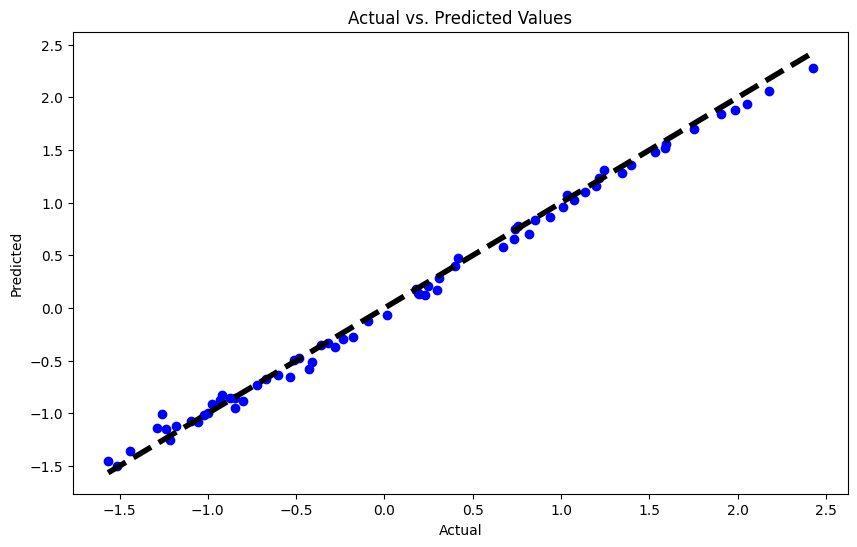

In [49]:

# plot actual vs predicted values for visual comparison

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue')  # actual values in blue
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # line for perfect predictions
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()
        